# Factory Planning
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vitostamatti/mathematical-optimization-pyomo/blob/main/notebooks/02-factory_planning.ipynb)


A factory makes seven products (Prod 1 to Prod 7) using a range of machines including:

- Four grinders
- Two vertical drills
- Three horizontal drills
- One borer
- One planer

Each product has a defined profit contribution per unit sold (defined as the sales price per unit minus the cost of raw materials). In addition, the manufacturing of each product requires a certain amount of time on each machine (in hours). The profit and manufacturing time value are shown below. A dash indicates that the manufacturing process for the given product does not require that machine.

| <i></i> | PROD1 | PROD2 | PROD3 | PROD4 | PROD5 | PROD6 | PROD7 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Profit | 10 | 6 | 8 | 4 | 11 | 9 | 3 |
| Grinding | 0.5 | 0.7 | - | - | 0.3 | 0.2 | 0.5 |
| Vertical Drilling | 0.1 | 0.2 | - | 0.3 | - | 0.6 | - |
| Horizontal Drilling | 0.2 | - | 0.8 | - | - | - | 0.6 |
| Boring | 0.05 | 0.03 | - | 0.07 | 0.1 | - | 0.08 |
| Planning | - | - | 0.01 | - | 0.05 | - | 0.05 |


The maintenance requirements are as follows:

- Each machine must be down for maintenance in one month of the six.
- The exception to the above are the grinding machines as only two of them need to be down during the six months.

There are limitations on how many of each product can be sold in a given month. These limits are shown below:

| Month | PROD1 | PROD2 | PROD3 | PROD4 | PROD5 | PROD6 | PROD7 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| January | 500 | 1000 | 300 | 300 | 800 | 200 | 100 |
| February | 600 | 500 | 200 | 0 | 400 | 300 | 150 |
| March | 300 | 600 | 0 | 0 | 500 | 400 | 100 |
| April | 200 | 300 | 400 | 500 | 200 | 0 | 100 |
| May | 0 | 100 | 500 | 100 | 1000 | 300 | 0 |
| June | 500 | 500 | 100 | 300 | 1100 | 500 | 60 |

Up to 100 units of each product may be stored in inventory at a cost of $0.50 per unit per month. At the start of January, there is no product inventory. However, by the end of June, there should be 50 units of each product in inventory.

The factory produces products six days a week using two eight-hour shifts per day. It may be assumed that each month consists of 24 working days. Also, for the purposes of this model, there are no production sequencing issues that need to be taken into account.

What should the production and maintenance plans look like? Also, is it possible to recommend any price increases and determine the value of acquiring any new machines?

In [3]:
import pandas as pd
import numpy as np
# import cplex
import pyomo.environ as pyo

In [2]:
# Parameters
products = ["Prod1", "Prod2", "Prod3", "Prod4", "Prod5", "Prod6", "Prod7"]
machines = ["grinder", "vertDrill", "horiDrill", "borer", "planer"]
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun"]

profit = {"Prod1":10, "Prod2":6, "Prod3":8, "Prod4":4, "Prod5":11, "Prod6":9, "Prod7":3}

time_req = {
    "grinder": {    "Prod1": 0.5, "Prod2": 0.7, "Prod5": 0.3,
                    "Prod6": 0.2, "Prod7": 0.5 },
    "vertDrill": {  "Prod1": 0.1, "Prod2": 0.2, "Prod4": 0.3,
                    "Prod6": 0.6 },
    "horiDrill": {  "Prod1": 0.2, "Prod3": 0.8, "Prod7": 0.6 },
    "borer": {      "Prod1": 0.05,"Prod2": 0.03,"Prod4": 0.07,
                    "Prod5": 0.1, "Prod7": 0.08 },
    "planer": {     "Prod3": 0.01,"Prod5": 0.05,"Prod7": 0.05 }
}

# number of each machine available
installed = {"grinder":4, "vertDrill":2, "horiDrill":3, "borer":1, "planer":1} 

# number of machines that need to be under maintenance
down_req = {"grinder":2, "vertDrill":2, "horiDrill":3, "borer":1, "planer":1} 

# market limitation of sells
max_sales = {
    ("Jan", "Prod1") : 500,
    ("Jan", "Prod2") : 1000,
    ("Jan", "Prod3") : 300,
    ("Jan", "Prod4") : 300,
    ("Jan", "Prod5") : 800,
    ("Jan", "Prod6") : 200,
    ("Jan", "Prod7") : 100,
    ("Feb", "Prod1") : 600,
    ("Feb", "Prod2") : 500,
    ("Feb", "Prod3") : 200,
    ("Feb", "Prod4") : 0,
    ("Feb", "Prod5") : 400,
    ("Feb", "Prod6") : 300,
    ("Feb", "Prod7") : 150,
    ("Mar", "Prod1") : 300,
    ("Mar", "Prod2") : 600,
    ("Mar", "Prod3") : 0,
    ("Mar", "Prod4") : 0,
    ("Mar", "Prod5") : 500,
    ("Mar", "Prod6") : 400,
    ("Mar", "Prod7") : 100,
    ("Apr", "Prod1") : 200,
    ("Apr", "Prod2") : 300,
    ("Apr", "Prod3") : 400,
    ("Apr", "Prod4") : 500,
    ("Apr", "Prod5") : 200,
    ("Apr", "Prod6") : 0,
    ("Apr", "Prod7") : 100,
    ("May", "Prod1") : 0,
    ("May", "Prod2") : 100,
    ("May", "Prod3") : 500,
    ("May", "Prod4") : 100,
    ("May", "Prod5") : 1000,
    ("May", "Prod6") : 300,
    ("May", "Prod7") : 0,
    ("Jun", "Prod1") : 500,
    ("Jun", "Prod2") : 500,
    ("Jun", "Prod3") : 100,
    ("Jun", "Prod4") : 300,
    ("Jun", "Prod5") : 1100,
    ("Jun", "Prod6") : 500,
    ("Jun", "Prod7") : 60,
}

holding_cost = 0.5
max_inventory = 100.0
store_target = 50.0
hours_per_month = 2*8*24

In [5]:
def build_model():
    m = pyo.ConcreteModel()
    
    # SETS 
#     m.T = Set(initialize=months,ordered=True, doc='Months')
#     m.P = Set(initialize=products, doc='Products')
#     m.MC = Set(initialize=machines, doc='Machines')
    
    # VARIABLES
    m.make = pyo.Var(months, products, domain=pyo.Reals, doc='Make')
    m.store = pyo.Var(months, products, domain=pyo.Reals, doc='Store')
    m.sell = pyo.Var(months, products, domain=pyo.Reals, doc='Sell')
    m.repair = pyo.Var(months, machines, domain=pyo.Integers, doc='Repair')
    
    m.z = pyo.Var(domain=pyo.Reals, doc='obj variable')
    
    m.constraints = pyo.ConstraintList()

    for month in months:
        for machine in machines:
            m.constraints.add(m.repair[month, machine] <= down_req[machine])
            m.constraints.add(m.repair[month, machine] >= 0)
    
    for month in months:
        for product in products:
            m.constraints.add(m.sell[month,product] <= max_sales[month,product])
            m.constraints.add(m.store[month,product] <= max_inventory)
            m.constraints.add(m.store[month,product] >= 0)
            m.constraints.add(m.make[month,product] >= 0)
    
    #Balance
    
    for product in products:
        for month in months:
            if months.index(month)==0:
                m.constraints.add(m.make[month,product] == m.sell[month,product] + m.store[month,product])
            else:
                m.constraints.add(
                    m.store[months[months.index(month)-1], product] 
                    + 
                    m.make[month,product] == m.sell[month,product] + m.store[month,product]
                    )
    
    #Capacity
    for month in months:
        for machine in machines:
            m.constraints.add(sum(time_req[machine][product]*m.make[month, product] for product in time_req[machine]) <= hours_per_month*(installed[machine] - m.repair[month,machine]))
   
    #Inventory
    for product in products:
        m.constraints.add(m.store[months[-1],product] == store_target)
    

    #Maintenance
    
    for machine in machines:
        m.constraints.add(sum(m.repair[month, machine] for month in months) == down_req[machine])
    
    
    m.constraints.add(m.z == sum(m.make[month, product]*profit[product] - holding_cost*m.store[month,product] for month in months for product in products))
    
    #Objective
    def OBJ(m):
        return m.z
    
    m.obj = pyo.Objective(rule=OBJ, sense=pyo.maximize)
    
    
    return m

build_model()

In [9]:
m = build_model()
opt = pyo.SolverFactory("glpk")
results = opt.solve(m)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 111405.0
  Upper bound: 111405.0
  Number of objectives: 1
  Number of constraints: 314
  Number of variables: 158
  Number of nonzeros: 662
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 133
      Number of created subproblems: 133
  Error rc: 0
  Time: 0.058743953704833984
# ----------------------------------------------------------
#   Solution Information
# --------------------

In [34]:
rows = months.copy()
columns = products.copy()
df_max_sales = pd.DataFrame(columns=columns, index=rows, data=0.0)
for month, product in m.make.keys():
    df_max_sales.loc[month, product]=max_sales[(month,product)]

df_max_sales

,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7
Jan,500.0,1000.0,300.0,300.0,800.0,200.0,100.0
Feb,600.0,500.0,200.0,0.0,400.0,300.0,150.0
Mar,300.0,600.0,0.0,0.0,500.0,400.0,100.0
Apr,200.0,300.0,400.0,500.0,200.0,0.0,100.0
May,0.0,100.0,500.0,100.0,1000.0,300.0,0.0
Jun,500.0,500.0,100.0,300.0,1100.0,500.0,60.0


In [10]:
rows = months.copy()
columns = products.copy()
make_plan = pd.DataFrame(columns=columns, index=rows, data=0.0)

for month, product in m.make.keys():
    if (abs(m.make[month, product].value) > 1e-6):
        make_plan.loc[month, product] = np.round(m.make[month, product].value, 1)
make_plan

,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7
Jan,500.0,1000.0,300.0,300.0,800.0,200.0,100.0
Feb,600.0,500.0,200.0,0.0,400.0,300.0,150.0
Mar,400.0,700.0,100.0,100.0,600.0,400.0,200.0
Apr,0.0,0.0,0.0,0.0,0.0,0.0,0.0
May,0.0,100.0,500.0,100.0,1000.0,300.0,0.0
Jun,550.0,550.0,150.0,350.0,1150.0,550.0,110.0


<AxesSubplot:ylabel='Prod1'>

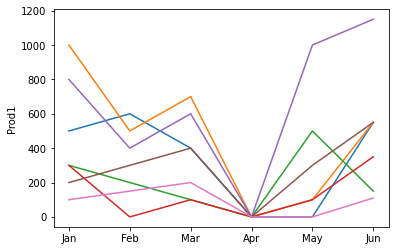

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
sns.lineplot(x=make_plan.index, y=make_plan.Prod1, palette="rocket", ax=ax)
sns.lineplot(x=make_plan.index, y=make_plan.Prod2, palette="rocket", ax=ax)
sns.lineplot(x=make_plan.index, y=make_plan.Prod3, palette="rocket", ax=ax)
sns.lineplot(x=make_plan.index, y=make_plan.Prod4, palette="rocket", ax=ax)
sns.lineplot(x=make_plan.index, y=make_plan.Prod5, palette="rocket", ax=ax)
sns.lineplot(x=make_plan.index, y=make_plan.Prod6, palette="rocket", ax=ax)
sns.lineplot(x=make_plan.index, y=make_plan.Prod7, palette="rocket", ax=ax)


In [11]:
rows = months.copy()
columns = products.copy()
sell_plan = pd.DataFrame(columns=columns, index=rows, data=0.0)

for month, product in m.sell.keys():
    if (abs(m.sell[month, product].value) > 1e-6):
        sell_plan.loc[month, product] = np.round(m.sell[month, product].value, 1)
sell_plan

,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7
Jan,500.0,1000.0,300.0,300.0,800.0,200.0,100.0
Feb,600.0,500.0,200.0,0.0,400.0,300.0,150.0
Mar,300.0,600.0,0.0,0.0,500.0,400.0,100.0
Apr,100.0,100.0,100.0,100.0,100.0,0.0,100.0
May,0.0,100.0,500.0,100.0,1000.0,300.0,0.0
Jun,500.0,500.0,100.0,300.0,1100.0,500.0,60.0


In [9]:
rows = months.copy()
columns = products.copy()
store_plan = pd.DataFrame(columns=columns, index=rows, data=0.0)

for month, product in m.store.keys():
    if (abs(m.store[month, product].value) > 1e-6):
        store_plan.loc[month, product] = np.round(m.store[month, product].value, 1)
store_plan

,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7
Jan,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Feb,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mar,100.0,100.0,100.0,100.0,100.0,0.0,100.0
Apr,0.0,0.0,0.0,0.0,0.0,0.0,0.0
May,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jun,50.0,50.0,50.0,50.0,50.0,50.0,50.0


In [10]:
rows = months.copy()
columns = machines.copy()
repair_plan = pd.DataFrame(columns=columns, index=rows, data=0.0)

for month, machine in m.repair.keys():
    if (abs(m.repair[month, machine].value) > 1e-6):
        repair_plan.loc[month, machine] = m.repair[month, machine].value
repair_plan

,grinder,vertDrill,horiDrill,borer,planer
Jan,0.0,0.0,1.0,0.0,0.0
Feb,0.0,1.0,0.0,0.0,0.0
Mar,0.0,0.0,2.0,0.0,0.0
Apr,2.0,0.0,0.0,1.0,1.0
May,0.0,1.0,0.0,0.0,0.0
Jun,0.0,0.0,0.0,0.0,0.0


## Inputs From Excel

In [92]:
df_products = pd.read_excel('../data/02-factory_planning/inputs.xlsx', sheet_name='products')
df_machines = pd.read_excel('../data/02-factory_planning/inputs.xlsx', sheet_name='machines')
df_max_sales = pd.read_excel('../data/02-factory_planning/inputs.xlsx', sheet_name='max_sales')
df_time_req = pd.read_excel('../data/02-factory_planning/inputs.xlsx', sheet_name='time_req')

In [93]:
products = df_products['product'].unique()
months = df_max_sales.columns[1:].to_list()
machines = df_machines['machine'].unique()

df_machines=df_machines.set_index('machine')
df_products=df_products.set_index('product')

df_max_sales = (
    df_max_sales
    .set_index('product')
    .stack()
    .reset_index()
    .rename(columns={
        'level_1':'months',
        0:'max_sales'
    })
    .set_index([
        'months',
        'product'
    ])
)

df_time_req = (
    df_time_req
    .assign(product=lambda df: df['product'].str.lower())
    .set_index(['machine','product'])
)


In [97]:
holding_cost = 0.5
max_inventory = 100.0
store_target = 50.0
hours_per_month = 2*8*24


In [95]:
def build_model():
    m = pyo.ConcreteModel()
    
    # VARIABLES
    m.make = pyo.Var(months, products, domain=pyo.Reals, doc='Make')
    m.store = pyo.Var(months, products, domain=pyo.Reals, doc='Store')
    m.sell = pyo.Var(months, products, domain=pyo.Reals, doc='Sell')
    m.repair = pyo.Var(months, machines, domain=pyo.Integers, doc='Repair')
    
    m.z = pyo.Var(domain=pyo.Reals, doc='obj variable')
    
    m.constraints = pyo.ConstraintList()

    for month in months:
        for machine in machines:
            m.constraints.add(m.repair[month, machine] <= df_machines.loc[machine,'down_req'])
            m.constraints.add(m.repair[month, machine] >= 0)
    
    for month in months:
        for product in products:
            m.constraints.add(m.sell[month,product] <= df_max_sales.loc[(month,product),'max_sales'])
            m.constraints.add(m.store[month,product] <= max_inventory)
            m.constraints.add(m.store[month,product] >= 0)
            m.constraints.add(m.make[month,product] >= 0)
    
    #Balance
    
    for product in products:
        for month in months:
            if months.index(month)==0:
                m.constraints.add(m.make[month,product] == m.sell[month,product] + m.store[month,product])
            else:
                m.constraints.add(
                    m.store[months[months.index(month)-1], product] + 
                    m.make[month,product] == 
                    m.sell[month,product] + 
                    m.store[month,product]
                    )
    
    #Capacity
    for month in months:
        for machine in machines:
            m.constraints.add(
                sum(
                    df_time_req.loc[(machine,product),'time_req']*m.make[month, product] 
                    for product in df_time_req.loc[machine].index.values
                    ) <= 
                    hours_per_month*(df_machines.loc[machine,'installed'] - 
                    m.repair[month,machine])
                )
   
    #Inventory
    for product in products:
        m.constraints.add(m.store[months[-1],product] == store_target)
    

    #Maintenance
    
    for machine in machines:
        m.constraints.add(sum(m.repair[month, machine] for month in months) == df_machines.loc[machine,'down_req'])
    
    
    m.constraints.add(m.z == 
        sum(m.make[month, product]*df_products.loc[product,'profit'] - 
        holding_cost*m.store[month,product] for month in months for product in products)
        )
    
    #Objective
    def OBJ(m):
        return m.z
    
    m.obj = pyo.Objective(rule=OBJ, sense=pyo.maximize)
    
    
    return m

build_model()

In [96]:
m = build_model()
# opt = pyo.SolverFactory("cplex")
opt = pyo.SolverFactory("glpk")
results = opt.solve(m)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 111405.0
  Upper bound: 111405.0
  Number of objectives: 1
  Number of constraints: 314
  Number of variables: 158
  Number of nonzeros: 650
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 55
      Number of created subproblems: 55
  Error rc: 0
  Time: 0.03853869438171387
# ----------------------------------------------------------
#   Solution Information
# -----------------------